# Exploring ``np.linalg.solve``

Author: Kai Striega
Date: 2024/4/18

# Who am I?

* Data engineer at BHP
* Programming since 2009
* Active in the scientific Python ecosystem
    * Maintainer of SciPy
    * Triage member of NumPy
* Like teaching and mentoring

# About this speech

* This speech is for **your** benefit!
    * Feel free to ask questions if something doesn't make sense
    * ...but raise your hand
* This speech covers:
    * A quick review of linear systems
    * How NumPy solves linear systems
    * SciPy's improvements for systems that are sparse or have special structure
* Slides are available at: https://github.com/Kai-Striega/speech-numpy-solve

# NumPy and SciPy

* NumPy and SciPy are libraries in Python
* Foundational in the scientific python ecosystem
* Downloaded >100 million times a month

NumPy provides:
<table>
    <tr>
        <td>
            <ul>
               <li>an n-dimensional array data structure (ndarray)</li>
               <li>simple mathematical functions to operate on these arrays (ufuncs)</li>
               <li>some extra functionality e.g. basic linear algebra and fourier transform</li>
            </ul>
        </td>
        <td>
             <img src="images/numpylogo.svg" width="240" height="240" align="center"/>
        </td>
    </tr>
       
</table>

SciPy provides more complex operations on Arrays including:
<table>
    <tr>
        <td>
            <ul>
               <li>optimization</li>
               <li>integration</li>
               <li>interpolation</li>
               <li>eigenvalue problems</li>
               <li>algebraic equations</li>
               <li>differential equations</li>
               <li>statistics</li>
               <li>many other classes of problems.</li>
            </ul>
        </td>
        <td>
            <img src="images/scipy_logo.svg" width="240" height="240" align="center"/>
        </td>
    </tr>
</table>


In [1]:
import numpy as np
import scipy as sp
from numpy.testing import assert_allclose
np.__version__, sp.__version__

('1.26.4', '1.13.0')

In [2]:
import perfplot
import matplotlib.pyplot as plt
import sympy

In [3]:
# Only sometimes run the benchmarks, this saves development time
RUN_BENCHMARKS = False

# What are Linear systems? (Revision)

## Linear Equations

* Linear equations take the form:

$$
f(x_1, x_2, \ldots, x_n) = a_1 x_1 + a_2 x_2 + \ldots + a_n x_n
$$

* in two dimensions, linear equations represent straight lines
* ...which you have probably seen in high school as $y = mx + b$
* in three dimensions linear equations represent planes

## Linear Systems

* It is also possible to have a _system_ of related linear equations
* For example we can have two equations with two variables:

$$
\begin{align}
b_1 =& a_{1, 1} x_1 + a_{1, 2} x_2 \\
b_2 =& a_{2, 1} x_1 + a_{2, 2} x_2 \\
\end{align}
$$

## Solutions to systems of linear equations

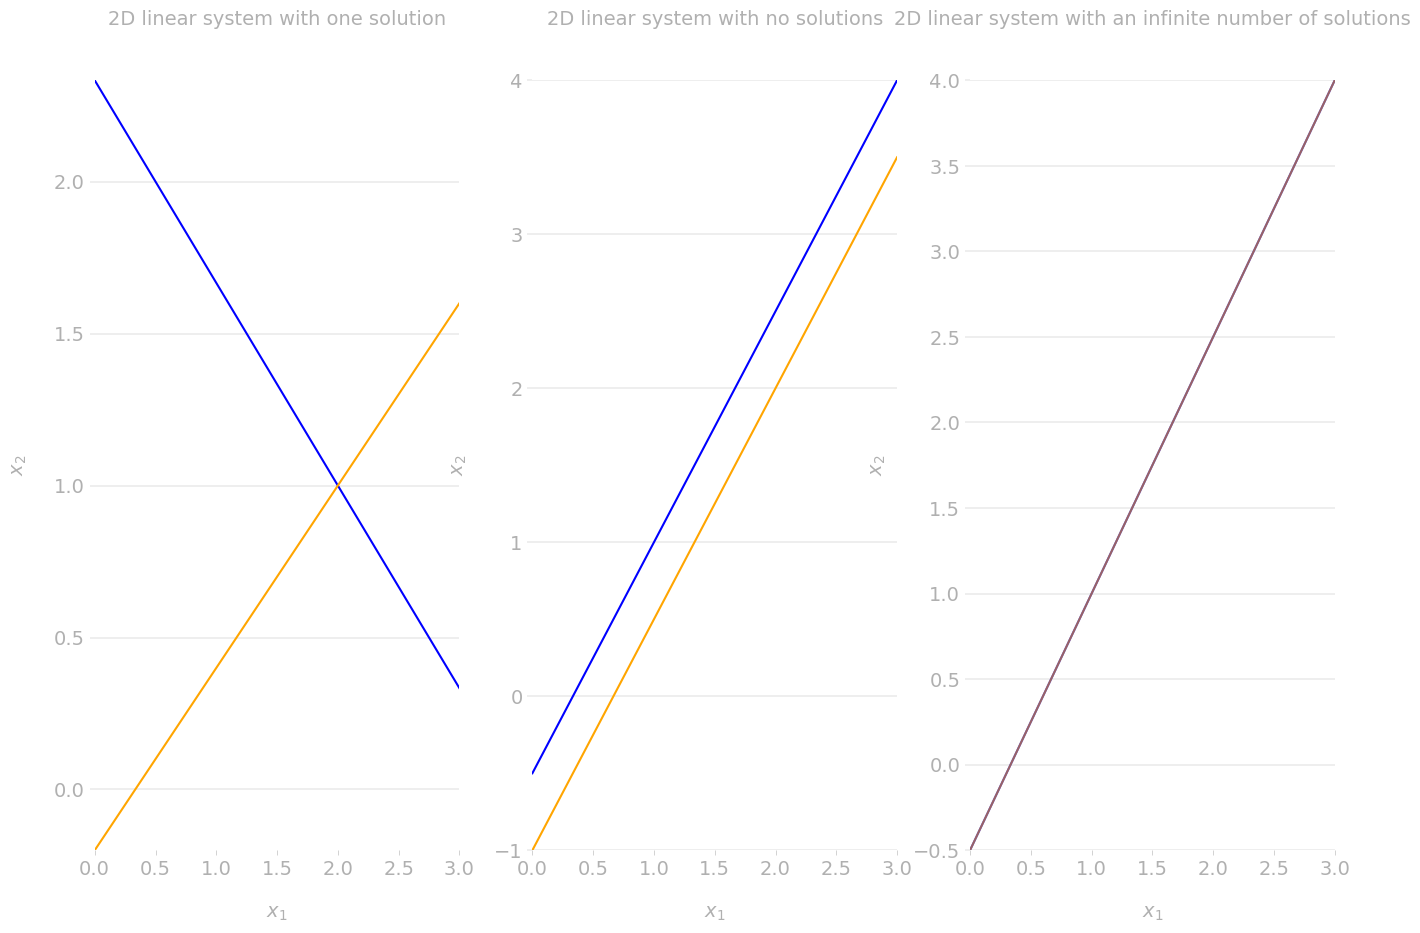

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 10))

t = np.linspace(0, 3)
y1 = 7 / 3 - 2 * t / 3
y2 = 3 * t / 5 - 1 / 5
y3 = -1 / 2 + 3 * t / 2
y4 = -1 + 3 * t / 2
y5 = -1 / 2 + 3 * t / 2

axs[0].set_title("2D linear system with one solution")
axs[0].plot(t, y1, 'blue')
axs[0].plot(t, y2, 'orange')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('$x_2$')
axs[0].set_xlabel('$x_1$')

axs[1].set_title("2D linear system with no solutions")
axs[1].plot(t, y3, 'blue')
axs[1].plot(t, y4, 'orange')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')

axs[2].set_title("2D linear system with an infinite number of solutions")
axs[2].plot(t, y5, 'blue', 0.6)
axs[2].plot(t, y5, 'orange', alpha=0.6)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_ylabel('$x_2$')
axs[2].set_xlabel('$x_1$')

plt.savefig("images/2d_system_of_eqs.png", transparent=True, bbox_inches="tight")
plt.show()

* A linear system can have:
    * a unique solution
    * infinitely many solutions
    * no solutions

![Possible 2D systems of equations](images/2d_system_of_eqs.png)

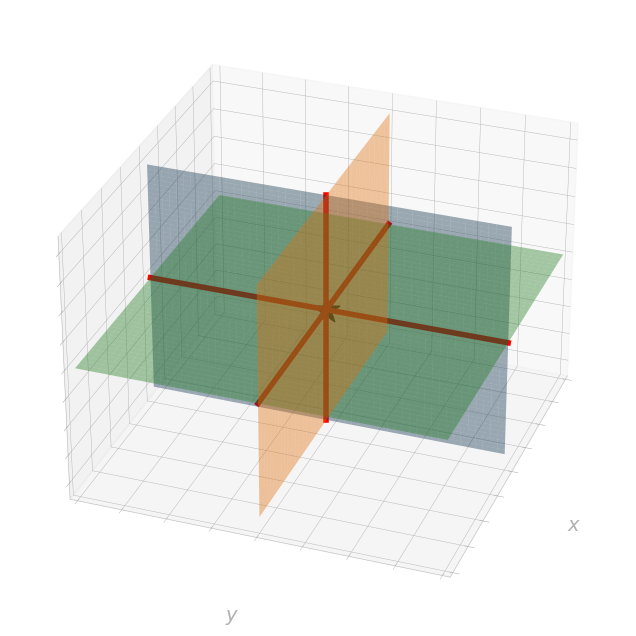

In [5]:
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)
z = np.linspace(-1, 1, 50)
X, Y, Z = np.meshgrid(x,y,z)
# horizontal planes with z = 0
z0 = np.zeros_like(X)

# another two plane with the equation: z1 = -10 * y + 10, z2 = 10 * y + 10
z1 = -10 * Y + 10
z2 = 10 * Y + 10
data = [z0, z1, z2]
colors = ["orange", "green", "blue"]

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in range(0, 3):
    oneDim = np.linspace(-1, 1, 50)
    otherDim = np.linspace(-1, 1, 50)
    oneDim, otherDim = np.meshgrid(oneDim, otherDim)
    data = [oneDim, otherDim]
    data.insert(i, np.zeros_like(oneDim))
    ax.plot_surface(data[0], data[1], data[2], alpha=0.4, zorder=1)
ax.set_xlabel(r"$x$")
ax.set_xticklabels([])
ax.set_ylabel(r"$y$")
ax.set_yticklabels([])
ax.set_zlabel(r'$z$')
ax.set_zticklabels([])

# use sympy to solve the two intersection lines
x, y, z = sympy.symbols('x, y, z')
eq0 = sympy.Eq(z, 0)
eq1 = sympy.Eq(y, 0)
eq2 = sympy.Eq(x, 0)
sol = sympy.solve([eq0, eq1, eq2], dict=True)
sol01 = sympy.solve([eq0, eq1], dict=True)
sol02 = sympy.solve([eq0, eq2], dict=True)
sol12 = sympy.solve([eq1, eq2], dict=True)

ax.plot(np.linspace(-1, 1, 10),
        np.ones(10) * sol01[0][y],
        np.ones(10) * sol01[0][z],
        linewidth=4, color='red')
ax.plot(np.ones(10) * sol02[0][x],
        np.linspace(-1, 1, 10),        
        np.ones(10) * sol02[0][z],
        linewidth=4, color='red')
ax.plot(np.ones(10) * sol12[0][x],
        np.ones(10) * sol12[0][y],
        np.linspace(-1, 1, 10),
        linewidth=4, color='red')
ax.scatter(sol[0][x], sol[0][y], sol[0][z], marker='*', s=400, color='k')
ax.view_init(elev=30, azim=20)

plt.savefig("images/3d_system_of_equations_with_unique_solution.png", transparent=True, bbox_inches="tight")
plt.show()


## And in 3 dimensions

![A 3D linear system with a unique solution](images/3d_system_of_equations_with_unique_solution.png)

## Linear systems in matrix form

* Consider the general linear system:

$$
\begin{align}
b_1 =& a_{1, 1} x_1 + a_{1, 2} x_2 + \ldots + a_{1, n} x_n \\
b_2 =& a_{2, 1} x_1 + a_{2, 2} x_2 + \ldots + a_{2, n} x_n \\
\vdots \\
b_n =& a_{n, 1} x_1 + a_{n, 2} x_2 + \ldots + a_{n, n} x_n
\end{align}
$$

* We can rewrite this using matrices as:

$$
\begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_n \end{bmatrix}
=
\begin{bmatrix}
a_{1, 1} & a_{1, 2} & \ldots & a_{1, n} \\
a_{2, 1} & a_{2, 2} & \ldots & a_{2, n} \\
\vdots & & & \\
a_{n, 1} & a_{n, 2} & \ldots & a_{n, n} \\
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}
$$

# Problem Statement

Consider the system of linear equations:

$$ Ax = b $$

Where: 

* $A$ is a known, invertible $n\text{ x }n$ matrix
* $x$ is an unknown $n$ dimensional vector
* $b$ is a known $n$ dimensional vector

We want to be able to solve this system for $x$.

* We've all solved these kind of problems by hand
* In applications the problem size is usually huge
* In this case we need to develop algorithms to let a computer do the job
* Well, we don't, because they have already been written

In [6]:
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]])

b = np.array([8, -11, -3])
x = np.linalg.solve(A, b)

A @ x

array([  8., -11.,  -3.])

In [7]:
rng = np.random.default_rng(42)
n = 10_000
A = rng.random((n, n))
b = rng.random(n)
x = np.linalg.solve(A, b)
assert_allclose(A @ x, b)

## Great!

* We have reduced a whole subfield of mathematics into a single line of NumPy.
* But I like to __understand__ how a method works, not just use it
* This talk will look at __how__ to solve this type of equation

# How does NumPy do it?

* NumPy defines the ``solve`` function in [umath_linalg.cpp](https://github.com/numpy/numpy/blob/370f1e5c2d24b2fc4b49152c92bafbcb0384346b/numpy/linalg/umath_linalg.cpp#L1768-L1803)
* NumPy calls the [LAPACK](https://en.wikipedia.org/wiki/LAPACK) routine ``_dgesv``
* There are multiple implementations of LAPACK
* The reference implementation of ``_dgesv`` is available on [Netlib](https://netlib.org/lapack/explore-html-3.6.1/d7/d3b/group__double_g_esolve_ga5ee879032a8365897c3ba91e3dc8d512.html)

# Digression: Matrix inversion

* From our maths classes, we know that we can invert a matrix to solve a system of equations
* This can be used to solve a system of equations:
$$
\begin{align}
Ax &= b \\
A^{-1}Ax &= A^{-1}b \\
x &= A^{-1}b \\
\end{align}
$$

In [8]:
x = np.linalg.inv(A) @ b
assert_allclose(A @ x, b)

## Why we don't use matrix inversion

### Benchmarks

In [9]:
%timeit np.linalg.inv(A) @ b

6.83 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit np.linalg.solve(A, b)

2.23 s ± 65.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
if RUN_BENCHMARKS:
    out = perfplot.bench(
        setup=lambda n: (rng.random((n, n)), rng.random(n)), 
        kernels=[
            lambda A, b: np.linalg.solve(A, b),
            lambda A, b: np.linalg.inv(A) @ b,
        ],
        labels=["np.linalg.solve", "np.linalg.inv"],
        n_range=range(0, 20_000, 250),
        xlabel="Size of system",
    )
    out.save("images/inv_vs_solve.png", transparent=True, bbox_inches="tight")
    out.show()

### How NumPy calculates an inverse

* Calculating an inverse directly is _slow_
* We can see how NumPy does it from the [source code](https://github.com/numpy/numpy/blob/370f1e5c2d24b2fc4b49152c92bafbcb0384346b/numpy/linalg/umath_linalg.cpp#L1805-L1839)
* It solves the linear system $AA^{-1} = I$ to find the inverse
* Calling `np.linalg.inv(A) @ b` is equivalent to calling `np.linalg.solve(A, np.eye(n)) @ b`

# LU Factorization

* Basic idea: Convert $A$ to an upper triangular matrix by multiplying by finitely many lower triangular matrices

$$ E_{n-1} \dots  E_2 E_1 A = U $$

* With some rearranging, this leads to the LU factorisation:
  
$$ 
\begin{align}
A &= E_1^{-1}E_2^{-1} \ldots E_{n-1}^{-1}U \\
&= L_1 L_2 \ldots L_{n-1} U \\
&= LU
\end{align}
$$

## Solving linear systems using LU Factorization

* Consider the linear system $$Ax = b$$ with LU factorisation $$ A = LU $$. 
* Now we have $LUx = b$. Set $y = Ux$ Then the solution for $Ax=b$ can be found in two steps:
    1. Solve the system $Ly=b$ for $y$ by _forward substitution_
    2. Solve the system $Ux=y$ for $x$ by _back substitution_

### Forward substitution

Consider the system $Ly=b$:

$$ Ly = 
\begin{bmatrix}
l_{1, 1} & 0 & \ldots & 0 \\ 
l_{2, 1} & l_{2, 2} & & \vdots\\
\vdots & & \ddots & 0 \\
l_{n, 1} & l_{n, 2} & \ldots & l_{n,n}
\end{bmatrix}
\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
= 
\begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_n \end{bmatrix}
$$

By the first equation we get $$y_1 = \frac{b_1}{l_{1,1}}$$ 

Then, by induction, it can be shown that the solution is given by forward substitution:

$$ y_i = \frac{b_i - \sum_{k=1}^{i-1} l_{i,k}y_k}{l_{i,i}} $$

### Back Substitution

* We now know $y$ we need to solve the system $Ux=y$ for $x$ by back substitution:

$$ U = 
\begin{bmatrix}
u_{1, 1} & u_{1,2} & \ldots & u_{1,n} \\ 
0 & l_{2, 2} & \ldots & u_{2,n}\\
\vdots & & \ddots & \vdots \\
0 & \ldots & 0 & u_{n,n}
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}
= 
\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
$$

* By the last equation we obtain: $$ x_n = \frac{y_n}{u_{n,n}} $$ 
* By induction we can solve the solution $x$ by back substitution:

$$ x_i = \frac{y_i - \sum_{k=i + 1}^{n} u_{i,k}x_k}{u_{i,i}} $$

##  All that in code

In [12]:
def lu(A):
    
    #Get the number of rows
    n = A.shape[0]
    
    U = A.copy().astype(np.float64)
    L = np.eye(n, dtype=np.float64)

    for i in range(n):
            
        # Eliminate entries below i with row operations 
        # on U and reverse the row operations to 
        # manipulate L
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
        
    return L, U

In [13]:
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]])
b = np.array([8, -11, -3])

L, U = lu(A)

In [14]:
L

array([[ 1. ,  0. ,  0. ],
       [-1.5,  1. ,  0. ],
       [-1. ,  4. ,  1. ]])

In [15]:
U

array([[ 2. ,  1. , -1. ],
       [ 0. ,  0.5,  0.5],
       [ 0. ,  0. , -1. ]])

In [16]:
L @ U

array([[ 2.,  1., -1.],
       [-3., -1.,  2.],
       [-2.,  1.,  2.]])

In [17]:
assert_allclose(L @ U, A)

In [18]:
def forward_substitution(L, b):
    
    # Get number of rows
    n = L.shape[0]
    
    # Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    
    # Here we perform the forward-substitution.  
    # Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    
    # Looping over rows in reverse (from the bottom  up),
    # starting with the second to last row, because  the 
    # last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y

In [19]:
y = forward_substitution(L, b)
y

array([8., 1., 1.])

In [20]:
def back_substitution(U, y):
    
    # Number of rows
    n = U.shape[0]
    
    # Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);

    # Here we perform the back-substitution.  
    # Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    
    # Looping over rows in reverse (from the bottom up), 
    # starting with the second to last row, because the 
    # last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x

In [21]:
x = back_substitution(U, y)
x

array([ 2.,  3., -1.])

In [22]:
assert_allclose(A @ x, b)

# Problems with LU factorisation

## Problem 1: Backward instability

Consider the linear system $Ax=b$, where:

$$
A = \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 + \varepsilon & 5 \\ 4 & 6 & 8 \\ \end{bmatrix}, b = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}
$$

Then 

$$
E_1 A 
= \begin{bmatrix} 1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 0 \\ \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 + \varepsilon & 5 \\ 4 & 6 & 8 \\ \end{bmatrix} 
= \begin{bmatrix} 1 & 1 & 1 \\ 0 & \varepsilon & 3 \\ 0 & 2 & 4 \\ \end{bmatrix}
$$

And 

$$ E_2 E_1 A
= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & -\frac{2}{\varepsilon} & 1 \\ \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\ 0 & \varepsilon & 3 \\ 0 & 2 & 4 \\ \end{bmatrix}
= \begin{bmatrix} 1 & 1 & 1 \\ 0 & \varepsilon & 3 \\ 0 & 0 & 4-\frac{6}{\varepsilon} \\ \end{bmatrix}
$$

Which gives:

$$
L = \begin{bmatrix} 1 & 0 & 0 \\ 2 & 1 & 0 \\ 4 & \frac{2}{\varepsilon} & 1 \end{bmatrix}, U = \begin{bmatrix} 1 & 1 & 1 \\ 0 & \varepsilon & 3 \\ 0 & 0 & 4-\frac{6}{\varepsilon} \\ \end{bmatrix}
$$

* If $\varepsilon$ is on the order of machine accuracy, the $4$ in $4-\frac{6}{\varepsilon}$ becomes insignificant (because $\frac{6}{\varepsilon}$ is very large)
* This means that during computation we actually use:

$$ L^{\prime} = L, U^{\prime} = \begin{bmatrix} 1 & 1 & 1 \\ 0 & \varepsilon & 3 \\ 0 & 0 & -\frac{6}{\varepsilon} \\ \end{bmatrix} $$

But now:

$$ 
L^{\prime} U^{\prime}
= \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 + \varepsilon & 5 \\ 4 & 6 & 4 \\ \end{bmatrix}
\ne A
$$

... which is a problem

Furthermore if we use $L$ and $U$ to get $x$:

$$
x = \begin{bmatrix} \frac{4 \varepsilon - 7}{2 \varepsilon - 3} \\ \frac{2}{2\varepsilon - 3} \\ -\frac{2(\varepsilon - 1)}{2 \varepsilon - 3} \end{bmatrix}
\approx \begin{bmatrix} \frac{7}{3} \\ -\frac{2}{3} \\ -\frac{2}{3} \\ \end{bmatrix}
$$

While if we use $L^{\prime}$ and $U^{\prime}$:
$$
x^{\prime}
= \begin{bmatrix} \frac{11 - 2 \varepsilon}{3} \\ -2 \\ \frac{2\varepsilon - 2}{3} \end{bmatrix}
\approx \begin{bmatrix} \frac{11}{3} \\ -2 \\ -\frac{2}{3} \end{bmatrix}
$$

Clearly $x$ and $x^{\prime}$ are significantly different even when $L^{\prime}$ and $U^{\prime}$ are close to $L$ and $U$

## Problem 2: Not all matrices have an LU factorisation

Consider the matrix:

$$ A = \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 & 5 \\ 4 & 6 & 8 \\ \end{bmatrix} $$

Then:

$$ 
E_1 A 
= \begin{bmatrix} 1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1 \\ \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 & 5 \\ 4 & 6 & 8 \\ \end{bmatrix}
= \begin{bmatrix} 1 & 1 & 1 \\ 0 & 0 & 3 \\ 0 & 2 & 4 \\ \end{bmatrix}
$$

* The standard algorithm cannot go any further (since we would have to divide by zero)
* This implies that $A$ does not have an LU Factorisation

In [23]:
A = np.array([[1, 1, 1],
              [2, 2, 5],
              [4, 6, 8]])
lu(A)

/tmp/ipykernel_29953/2020444748.py:14: RuntimeWarning: divide by zero encountered in divide
  factor = U[i+1:, i] / U[i, i]
/tmp/ipykernel_29953/2020444748.py:16: RuntimeWarning: invalid value encountered in multiply
  U[i+1:] -= factor[:, np.newaxis] * U[i]


(array([[ 1.,  0.,  0.],
        [ 2.,  1.,  0.],
        [ 4., inf,  1.]]),
 array([[  1.,   1.,   1.],
        [  0.,   0.,   3.],
        [ nan,  nan, -inf]]))

## Pivoting

* Since the order of our equations does not matter we can swap rows
* We do this using a [permutation matrix](https://mathworld.wolfram.com/PermutationMatrix.html), $P_i$
* Each permutation matrix allows us to swap different rows

* Let's look at column 1 of $A$
* We can see the number of largest magnitude is 4
* Let's swap rows 1 and 3

$$ P_1 A
= \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0 \\ \end{bmatrix} \begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 & 5 \\ 4 & 6 & 8 \\ \end{bmatrix} 
= \begin{bmatrix} 4 & 6 & 8 \\ 2 & 2 & 5 \\ 1 & 1 & 1 \\ \end{bmatrix} 
$$

* We can now perform the first step of the algorithm

$$ 
E_1 P_1 A
= \begin{bmatrix} 1 & 0 & 0 \\ -\frac{1}{2} & 1 & 0 \\ -\frac{1}{4} & 0 & 1 \\ \end{bmatrix} \begin{bmatrix} 4 & 6 & 8 \\ 2 & 2 & 5 \\ 1 & 1 & 1 \\ \end{bmatrix}
= \begin{bmatrix} 4 & 6 & 8 \\ 0 & -1 & 1 \\ 0 & -\frac{1}{2} & -1 \\ \end{bmatrix}
$$

* We can now continue with our algorithm, pivoting as required

* In general, back instability can be avoided by swapping rows before applying $E_k$ i.e. we perform:

$$
E_{n-1}P_{n-1} \ldots E_2P_2E_1P_1A = U
$$

* With some rejiggling, this can be transformed to show that

$$ PA = LU $$

* i.e. we have some permutation matrix $P$ that, when multiplied with $A$, gives us the LU factorisation

# Can we do better?

* LU Factorisation is good for dense, small systems
* However, in reality many problems are  sparse, large or have special structure
* [SciPy](https://scipy.org/) contains solvers for sparse systems or systems with special structure

## scipy.linalg

* Includes paths for dense matrices of special structure
    * ``solve``: symmetric, hermitian and positive definite matrices
    * ``solve_banded``
    * ``solveh_banded``
    * ``solve_circulant``
    * ``solve_triangular``
    * ``solve_toeplitz``

## scipy.sparse.linalg.spsolve

* Takes a ndarray or sparse system and solves it
* Will convert ndarrays to a CSC or CSR array
* This will add overhead
* Recommend to use sparse arrays when working with sparse systems

### CSR Arrays

* Compressed Sparse Row Array
* Stores the data in three 1-D arrays:
    * __V__ stores the values as rows contiguously
    * __COL_INDEX__ stores the column index
    * __ROW_INDEX__ stores the row index
* This format lets us access _rows_ very efficiently

In [24]:
def create_sparse_system(n, p, rng):
    # Create a nxn sparse system by zeroing p% of rows
    A = rng.random((n, n))
    b = rng.random(n)
    row_ind = rng.choice(np.arange(n), int(n * p / 100), replace=False)
    A[row_ind, :] = 0
    np.fill_diagonal(A, 1)  # Make sure a valid solution exists
    return A, sp.sparse.csr_array(A), b

In [25]:
D, S, b = create_sparse_system(10_000, 99, rng)

In [26]:
%timeit np.linalg.solve(D, b)

2 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit sp.sparse.linalg.spsolve(D, b)

<magic-timeit>:1: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


385 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit sp.sparse.linalg.spsolve(S, b)

18.2 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Sparse arrays are not a panacea

In [29]:
if RUN_BENCHMARKS:
    N = 1_000
    out = perfplot.bench(
        setup=lambda p: create_sparse_system(N, p, rng),
        kernels=[
            lambda A, S, b: np.linalg.solve(A, b),
            lambda A, S, b: sp.sparse.linalg.spsolve(S, b),
        ],
        labels=["np.linalg.solve", "sp.sparse.linalg.spsolve"],
        n_range=range(100),
        xlabel="Sparsity (percent of rows zeroed)",
    )
    out.title = f"Runtime required to find the solution of a {N} x {N} linear system"
    out.show()
    out.save("images/sparsity.png", transparent=True, bbox_inches="tight")

![Runtime of solve vs spsolve as sparsity increases](images/sparsity.png)

# Questions / Comments?